# Analyzing San Diego's Housing Auction Data

### Background

When an owner of a property has not paid taxes for the property, that property can go on auction by the county's tax collector. The public then has an opportunity to pay off the taxes owed on the property and take ownership of the property.

Before an auction, a workbook is dispersed with the properties that will go for auction. As an investor, how can we estimate what a winning bid might be? This information would be very valuable to estimate to determine if a property could potentially be profitable to invest in. The auction data that we will be using comes from the San Diego tax collector website. We will use the historical auction data to estimate the upcoming auction in March 2021. 

Along with auction data we will be using tax assessor data and data from Foursquare. These data sources will be used to supplement the historical auction data and support the model building process. The tax assessor data contains property details such as number of bedrooms, bathrooms and square footage. The Foursquare data will be used to search for nearby venues to a property. This information will be translated into a variable that can be used to refine our model to estimate a winning bid for a property.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Extract, Load and Transform Data Sources</a>

    a.  <a href="#item1a">Upcoming Auction Data</a>
    
    b.  <a href="#item1b">Historical Auction Data</a>
    
    c.  <a href="#item1c">Foursquare Data</a> 
    
    d.  <a href="#item1d">Tax Assessor Parcel Data</a>
    
    e.  <a href="#item1e">Merge on Tax Assessor Data onto Auction Datasets</a> 

2. <a href="#item2">Create Model of Winning Bids with Historical Auction Data</a>
    
3. <a href="#item3">Analysis of Potential Profit</a>
    
    a.  <a href="#item3a">Estimate Winning Bids</a>
    
    b.  <a href="#item3b">Estimate Sale Prices with Zestimate API</a>
    
    c.  <a href="#item3c">Calculate Potential Profit for each Property</a>
    
4. <a href="#item4">Conclusion and Recommendations</a>
    
</font>
</div>

<a id='item1'></a>

## Extract, Load and Transform Data Sources

In [1]:
# Load needed libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import re #for regular expression use

import glob #to read all files of a directory

pd.set_option('display.max_columns', None)

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py

<a id='item1a'></a>

### Upcoming Auction Data

<a id='item1a'></a>

In [2]:
# Read in auction data
# This data was downloaded from the San Diego tax collector website and filtered for only "IMPROVED PROPERTIES"

auctiondata = pd.read_excel('3_17_2021_Auction_List_ImprovedProperty_20210215_2040.xls')

print(auctiondata.shape)
    
auctiondata.head()

# Let's briefly explore the data
#auctiondata.describe(include='all')

(63, 15)


,ID#,APN,Street Address,Tax Rate Area,Land Value,Improvements,Total Assessed Value,Assessed Value Year,Property Description,Your Max Bid,Opening Bid,Best Bid,Status,Close(PDT),Canceled
0,5,1023622000,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,93011,116469,88498,204967,2020,(EX RD)PAR A PER DOC89-510014 IN SEQ OF SEQ SE...,0,101000,0,-,2021-03-15 08:00:00,NaN
1,22,1211304300,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,75015,124409,348619,473028,2020,DOC59-6680 IN SWQ SEC 13-10-4W,0,232000,0,-,2021-03-15 08:00:00,NaN
2,23,1213223100,3816 CAZADOR LN FALLBROOK CA 92028-8880,75009,225195,225195,450390,2020,PAR 3,0,221000,0,-,2021-03-15 08:00:00,NaN
3,27,1233402300,4577 LA CANADA RD FALLBROOK CA 92028-9488,75013,103536,169812,273348,2020,POR LOT 58,0,134000,0,-,2021-03-15 08:00:00,NaN
4,34,1292110800,10079 W LILAC RD ESCONDIDO CA 92026-5308,94099,169793,318362,488155,2020,(EX ST) PAR 3,0,240000,0,-,2021-03-15 08:00:00,NaN


In [3]:
# Let's clean up the data a bit, by dropping columns without any useful data

auctiondata2 = auctiondata.drop(columns=['Assessed Value Year','Your Max Bid','Best Bid','Status','Close(PDT)'])

# We will only be focusing on properties that have not been cancelled yet

auctiondata2.groupby('Canceled').count()

# 21 properties have been cancelled. We should expect 63 - 21 = 42 remaining properties

auctiondata3 = auctiondata2[auctiondata2.Canceled.isnull()].reset_index(drop=True)
print(auctiondata3.shape)
auctiondata3.head()

(42, 10)


,ID#,APN,Street Address,Tax Rate Area,Land Value,Improvements,Total Assessed Value,Property Description,Opening Bid,Canceled
0,5,1023622000,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,93011,116469,88498,204967,(EX RD)PAR A PER DOC89-510014 IN SEQ OF SEQ SE...,101000,NaN
1,22,1211304300,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,75015,124409,348619,473028,DOC59-6680 IN SWQ SEC 13-10-4W,232000,NaN
2,23,1213223100,3816 CAZADOR LN FALLBROOK CA 92028-8880,75009,225195,225195,450390,PAR 3,221000,NaN
3,27,1233402300,4577 LA CANADA RD FALLBROOK CA 92028-9488,75013,103536,169812,273348,POR LOT 58,134000,NaN
4,34,1292110800,10079 W LILAC RD ESCONDIDO CA 92026-5308,94099,169793,318362,488155,(EX ST) PAR 3,240000,NaN


In [14]:
#Loop through our auction notebook and get lat/longs for each row.

Latitude = []
Longitude = []

geolocator = Nominatim(user_agent="explorer")

for addy in auctiondata3['Street Address']:
    
    try:
        location = geolocator.geocode(addy)
        lat = location.latitude
        long = location.longitude
        Latitude.append(lat)
        Longitude.append(long)
    except AttributeError:
        try:
            addy2 = re.sub(r'#(\w+)','',addy)
            location = geolocator.geocode(addy2)
            lat = location.latitude
            long = location.longitude
            Latitude.append(lat)
            Longitude.append(long)
        except AttributeError:
            try:
                # There are a few addresses still not returning lat/long coordinates
                # If there were several addresses left, we could do further parsing like keep only the address and zipcode...this was working for some
                # Instead, we'll manually look up the last 7 addresses
                if addy2=='5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844':
                    lat=33.426140
                    long=-117.102790
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy2=='29548 MEADOW GLEN WAY W ESCONDIDO CA 92026-6513':
                    lat=33.232420
                    long=-117.127710
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy2=='4185 MT ALIFAN PL  SAN DIEGO CA 92111-2830':
                    lat=32.816430
                    long=-117.179200
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy2=='1750 RIDGE CREEK DR BONITA CA 91902-4048':
                    lat=32.654170
                    long=-116.993850
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy2=='2039 DAIRY MART RD  SAN YSIDRO CA 92173-1860':
                    lat=32.56092865816545
                    long=-117.06072767329297
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy=='39052 HIGHWAY 80 BOULEVARD CA 91905':
                    lat=32.704231394280654
                    long=-116.36009905151758
                    Latitude.append(lat)
                    Longitude.append(long)
                elif addy=='24080 HIGHWAY 94 POTRERO CA 91963-4010':
                    lat=32.60915872013456
                    long=-116.6306572807044
                    Latitude.append(lat)
                    Longitude.append(long)
            except:
                print(addy)
                

print(len(Latitude),len(Longitude),auctiondata3.shape)

auctiondata3['Latitude']=Latitude
auctiondata3['Longitude']=Longitude
auctiondata3.head()

42 42 (42, 10)


,ID#,APN,Street Address,Tax Rate Area,Land Value,Improvements,Total Assessed Value,Property Description,Opening Bid,Canceled,Latitude,Longitude
0,5,1023622000,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,93011,116469,88498,204967,(EX RD)PAR A PER DOC89-510014 IN SEQ OF SEQ SE...,101000,NaN,33.426140,-117.102790
1,22,1211304300,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,75015,124409,348619,473028,DOC59-6680 IN SWQ SEC 13-10-4W,232000,NaN,33.306046,-117.261136
2,23,1213223100,3816 CAZADOR LN FALLBROOK CA 92028-8880,75009,225195,225195,450390,PAR 3,221000,NaN,33.323474,-117.254032
3,27,1233402300,4577 LA CANADA RD FALLBROOK CA 92028-9488,75013,103536,169812,273348,POR LOT 58,134000,NaN,33.308012,-117.224602
4,34,1292110800,10079 W LILAC RD ESCONDIDO CA 92026-5308,94099,169793,318362,488155,(EX ST) PAR 3,240000,NaN,33.275190,-117.113335


In [15]:
# create map of San Diego using latitude and longitude values with markers for auction properties
sd_lat = 32.7157
sd_long= -117.1611

map_sd = folium.Map(location=[sd_lat, sd_long], zoom_start=9)

# add markers to map
for lat, lng, bid, value, addy in zip(auctiondata3['Latitude'], auctiondata3['Longitude'], auctiondata3['Opening Bid'], auctiondata3['Total Assessed Value'],auctiondata3['Street Address']):
    label = 'Address: Opening Bid: {}, Total Assessed Value: {}'.format(bid, value)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sd)  
    
map_sd

<a id='item1b'></a>

### Historical Auction Data

In [16]:
# We will now read in the historical auction data

histauctdata = pd.read_csv('HistAuctionData.csv')
pd.to_numeric(histauctdata['Improvements'])

#We only want properties that are not timeshares, have a winning bid, and not land only
histauctdata2 = histauctdata[~histauctdata['Property Description'].str.contains("TIMESHARE") & ~histauctdata['Property Description'].str.contains("EXCL USE") & ~histauctdata['Winning Bid'].isnull() & histauctdata['Improvements'].gt(0)]
print(histauctdata2.shape)
histauctdata2.head()

(256, 13)


,ID#,APN,Address,Property Description,Tax Rate Area,Land Value,Improvements,Assessed Value,Assessed Value Year,Sale Date,Opening Bid,Winning Bid,Notes
2,20,1292923600,11146 OLD CASTLE RD VALLEY CENTER CA 92082-5605,18.94 AC M/L IN PAR 1,94050,519312,382992.0,902304,2019,3/4/2020,434000,950100.0,Forfeited
3,21,1293303400,30642 ROLLING HILLS DR VALLEY CENTER CA 92082-...,(EX DOCS53418REC70&amp;23787REC72)SWQ OF NEQ S...,94058,660572,30020.0,690592,2019,3/4/2020,332000,400100.0,Forfeited
35,150,4712710807,4314 48TH ST #07 SAN DIEGO CA 92115-4902,US 7 PER DOC79-524221&amp;UND INT IN LOTS 17&a...,8241,24288,69680.0,93968,2019,3/4/2020,47000,225100.0,NaN
40,179,5513801002,4398 DELTA ST #02 SAN DIEGO CA 92113-4184,US 2 PER DOC06-0855918&amp;UND INT IN LOT 1,8001,30009,43862.0,73871,2019,3/4/2020,37000,210100.0,NaN
43,235,6130804000,42748 HIGHWAY 80 JACUMBA CA 91934,DOC76-118620 IN E H OF E H SEC 35-17-7E,91044,337793,281494.0,619287,2019,3/4/2020,310000,310000.0,NaN


In [ ]:
#Loop through our historical auction dataframe and get lat/longs for each row.

Latitude = []
Longitude = []

geolocator = Nominatim(user_agent="explorer")

for addy in histauctdata2['Address']:
    
    try:
        location = geolocator.geocode(addy)
        lat = location.latitude
        long = location.longitude
        Latitude.append(lat)
        Longitude.append(long)
    except AttributeError:
        try:
            addy2 = re.sub(r'#(\w+)','',addy)
            location = geolocator.geocode(addy2)
            lat = location.latitude
            long = location.longitude
            Latitude.append(lat)
            Longitude.append(long)
        except:
            try:
                x = addy2.split()
                x = " ".join([x[len(x)-3],x[len(x)-2],x[len(x)-1]])
                print(x)
                location = geolocator.geocode(x)
                lat = location.latitude
                long = location.longitude
                Latitude.append(lat)
                Longitude.append(long)    
            except:
                print(addy2)
                Latitude.append(np.nan)
                Longitude.append(np.nan)  
                
                
#print(len(Latitude),len(Longitude),histauctdata2.shape)

histauctdata2['Latitude']=Latitude
histauctdata2['Longitude']=Longitude
histauctdata2.head()

<a id='item1c'></a>

### Foursquare Data

With the Foursquare data, we would like to measure a certain quality of life given the venues nearby a certain address. The idea is that if there are more sought after venues nearby an address, the higher the value of the home might be. If we had access to unlimited premium calls we could get a venue's details. With the Venue Details, we could see how expensive a venue might be. It makes sense that expensive venues are near expensive neighborhoods. For example, if there are many fast food restaurants around an address, one might think the property value would be lower than that of an address next to many upscale restaurants. Unfortunately, this project does not have the resources to make premium calls. If we did, we would definitely make a distinction between "cheap" and "upscale" venues based off of the "price" parameter given by a Foursquare premium call.

Instead, we will count the amount of venues for the following categories:

<ul>
    <li>Art Gallery (4bf58dd8d48988d1e2931735) and Museum (4bf58dd8d48988d181941735)</li>
    <li>Racecourse (56aa371be4b08b9a8d573514)</li>
    <li>Zoo (4bf58dd8d48988d17b941735)</li>
    <li>Golf Course (4bf58dd8d48988d1e6941735)</li>
    <li>Bay (56aa371be4b08b9a8d573544) and Beach (4bf58dd8d48988d1e2941735)</li>
    <li>National Park (52e81612bcbc57f1066b7a21) and Nature Preserve (52e81612bcbc57f1066b7a13)</li>
    <li>Emergency Room (4bf58dd8d48988d194941735)</li>
</ul>

These types of venues enrich a neighborhood and show private and public investment in the surrounding neighborhood. A count of these venues could serve to be a factor for the value of nearby properties. We will create a count of venue categories within 1 mile and then a separate count of the same venues, but within 5 miles.

Of course, there are many other venues that we could choose from that would be better indicators, but without the premium calls it is hard to make a count of venues a good factor.

In [ ]:
# We'll make Foursquare calls for venues nearby each address
# Define Foursquare Credentials and Version

CLIENT_ID = 'OQDOKECWR3AB5ARWGK021XOTJ0VMYKNJURXTHYDCFU53WVEK' # Foursquare ID
CLIENT_SECRET = 'P5RS1U5DLAHGQVASH5SIIR0SEWF0RCXYELM5AVMJT1J10UPM' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 10 # This the most amount we want for a nearby address

#Creating dataframes to loop through for the distances and venue categories that we are interested in
data = [['_1',1609.34], ['_5',5*1609.34]]
radii = pd.DataFrame(data, columns = ['name', 'distance']) 
print(radii)

data = [['Museum_Art','4bf58dd8d48988d1e2931735,4bf58dd8d48988d181941735'],['Racecourse','56aa371be4b08b9a8d573514'],['Zoo','4bf58dd8d48988d17b941735'],['GolfCourse','4bf58dd8d48988d1e6941735'],['Bay_Beach','56aa371be4b08b9a8d573544,4bf58dd8d48988d1e2941735'],['NtnlPark_Preserve','52e81612bcbc57f1066b7a21,52e81612bcbc57f1066b7a13'],['ER','4bf58dd8d48988d194941735']]
foursq_cats = pd.DataFrame(data, columns = ['Category', 'ID']) 
print(foursq_cats)

#Function for counting the amount of a particular venue around a lat, long coordinate
def AppendVenueCounts(df):
    for nm, radius in zip(radii.name, radii.distance):
        for catname, catid in zip(foursq_cats.Category, foursq_cats.ID):
            #df[catname+nm]=np.nan
            Add=[]
   #         for i, lat, lng in zip(range(len(df),df.Latitude, df.Longitude):
            for lat, lng in zip(df.Latitude, df.Longitude):
                url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT,catid)
                results = requests.get(url).json()
                try:
                    nearby_venues = json_normalize(results['response']['venues'])
                except:
                    nearby_venues = []
                Add.append(len(nearby_venues))
                #df[cat+] len(nearby_venues)
            df[catname+nm] = Add

Now we are ready to attach Foursquare data to our datasets (i.e. upcoming auction data and historical auction data).

In [40]:
#Apply function to each dataset to add on a count of nearby venues

AppendVenueCounts(auctiondata3)
auctiondata3.head()

#To not go over forusquare call limit, we will save completed files as a pickle file in our directory:
auctiondata3.to_pickle('auctiondata3')
#test = pd.read_pickle('auctiondata3')
#test.head()

AppendVenueCounts(histauctdata2)
histauctdata2.tail(10)

#Ran on 3/10/2021 at 9:45am...check Foursquare calls used
histauctdata2.to_pickle('histauctdata2')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


<a id='item1d'></a>

### Tax Assessor Parcel Data

In [3]:
# Installation needed to read in dbf files
pip install simpledbf

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/72/dd/df/cdfb970a508ef9750ebb4b6e035a3410c3d62b5a6a91d2aafc
Successfully built simpledbf
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Read in parcel data and convert to pandas dataframe

from simpledbf import Dbf5
dbf = Dbf5('PARCELS.dbf')
parceldata = dbf.to_dataframe()

PyTables is not installed. No support for HDF output.


In [8]:
# Check the contents and shape of our dataframe
print(parceldata.columns)
print(parceldata.shape)

Index(['APN', 'APN_8', 'PARCELID', 'OWN_NAME1', 'OWN_NAME2', 'OWN_NAME3',
       'FRACTINT', 'OWN_ADDR1', 'OWN_ADDR2', 'OWN_ADDR3', 'OWN_ADDR4',
       'OWN_ZIP', 'SITUS_JURI', 'SITUS_STRE', 'SITUS_SUFF', 'SITUS_POST',
       'SITUS_PRE_', 'SITUS_ADDR', 'SITUS_FRAC', 'SITUS_BUIL', 'SITUS_SUIT',
       'LEGLDESC', 'ASR_LAND', 'ASR_IMPR', 'ASR_TOTAL', 'DOCTYPE', 'DOCNMBR',
       'DOCDATE', 'ACREAGE', 'TAXSTAT', 'OWNEROCC', 'TRANUM', 'ASR_ZONE',
       'ASR_LANDUS', 'UNITQTY', 'SUBMAP', 'SUBNAME', 'NUCLEUS_ZO',
       'NUCLEUS_US', 'SITUS_COMM', 'YEAR_EFFEC', 'TOTAL_LVG_', 'BEDROOMS',
       'BATHS', 'ADDITION_A', 'GARAGE_CON', 'GARAGE_STA', 'CARPORT_ST', 'POOL',
       'PAR_VIEW', 'USABLE_SQ_', 'QUAL_CLASS', 'NUCLEUS_SI', 'NUCLEUS__1',
       'NUCLEUS__2', 'SITUS_ZIP', 'x_coord', 'y_coord', 'overlay_ju',
       'sub_type', 'multi', 'SHAPE_STAr', 'SHAPE_STLe'],
      dtype='object')
(1075406, 63)


In [ ]:
#Save to pickle file since the above process can take awhile
parceldata.to_pickle('parceldata')

<a id='item1e'></a>

### Merge on Tax Assessor Data onto Auction Datasets

The auction data alone does not give us enough information about the property to assess a winning bid. There are features of the property that we would like to know, such as the amount of bedrooms, bathrooms, square footage, etc. We will now merge on the tax assessor data to the auction datasets by the assessor's parcel number (APN). This parcel number uniquely identifies a property.

In [31]:
#Read in previously constructed dataframes

histauctdata2 = pd.read_pickle('histauctdata2').reset_index()
auctiondata3 = pd.read_pickle('auctiondata3').reset_index()
parceldata = pd.read_pickle('parceldata').reset_index()

#Data cleaning
parceldata['BEDROOMS'] = pd.to_numeric(parceldata['BEDROOMS']) 
parceldata['BATHS'] = pd.to_numeric(parceldata['BATHS'])/10

In [32]:
#Filter tax assessor data for columns that we will use

parceldata_merge = parceldata.filter(items=['APN', 'OWN_ADDR1', 'OWN_ADDR2', 'OWN_ADDR3', 'OWN_ADDR4','OWN_ZIP', 'SITUS_JURI', 'SITUS_STRE', 'SITUS_SUFF', 'SITUS_POST',
                                                'SITUS_PRE_', 'SITUS_ADDR', 'SITUS_FRAC', 'SITUS_BUIL', 'SITUS_SUIT', 'ASR_LAND', 'ASR_IMPR', 'ASR_TOTAL', 'ACREAGE',
                                                'YEAR_EFFEC', 'TOTAL_LVG_', 'BEDROOMS','BATHS', 'ADDITION_A', 'GARAGE_CON', 'GARAGE_STA', 'CARPORT_ST', 'POOL',
                                                'PAR_VIEW', 'USABLE_SQ_', 'NUCLEUS_SI','SITUS_ZIP'])
parceldata_merge['APN'] = pd.to_numeric(parceldata_merge['APN'])



In [33]:
#Merge on tax assessor data onto the auction datasets

histauctdata3 = histauctdata2.join(parceldata_merge.set_index('APN'), on='APN')
histauctdata3['Zipcode'] = histauctdata3['SITUS_ZIP'].apply(lambda x: x.split('-')[0])

auctiondata4 = auctiondata3.join(parceldata_merge.set_index('APN'), on='APN')
auctiondata4['Zipcode'] = auctiondata4['SITUS_ZIP'].apply(lambda x: x.split('-')[0])

#histauctdata3.groupby(['Zipcode']).size().reset_index(name='counts')
#auctiondata4.groupby(['Zipcode']).size().reset_index(name='counts')

<a id='item2'></a>

## Create Model of Winning Bids with Historical Auction Data

In [6]:
#Trim down our historical auction data for variables we will use

df = histauctdata3[['Land Value','Improvements','Opening Bid','Museum_Art_1','Racecourse_1','Zoo_1','GolfCourse_1','Bay_Beach_1','NtnlPark_Preserve_1','ER_1','Museum_Art_5','Racecourse_5',
        'Zoo_5','GolfCourse_5','Bay_Beach_5','NtnlPark_Preserve_5','ER_5','TOTAL_LVG_','BEDROOMS','BATHS','Winning Bid']].dropna()

#Let us quickly check to see which variables seem to be correlated with our "Winning Bid" target variable
df.corr()

,Land Value,Improvements,Opening Bid,Museum_Art_1,Racecourse_1,Zoo_1,GolfCourse_1,Bay_Beach_1,NtnlPark_Preserve_1,ER_1,Museum_Art_5,Racecourse_5,Zoo_5,GolfCourse_5,Bay_Beach_5,NtnlPark_Preserve_5,ER_5,TOTAL_LVG_,BEDROOMS,BATHS,Winning Bid
Land Value,1.000000,0.574107,0.897412,0.041142,0.082800,0.072305,0.060981,0.030804,0.174246,-0.033828,0.061052,0.028243,0.011018,0.252439,0.016764,0.130167,0.016279,0.361024,0.313858,0.230478,0.823684
Improvements,0.574107,1.000000,0.868863,-0.045621,-0.015620,-0.007765,-0.012305,-0.042750,0.239092,-0.053150,0.114216,-0.004560,-0.047091,0.188973,0.063355,0.069073,0.046439,0.714642,0.599713,0.513399,0.784275
Opening Bid,0.897412,0.868863,1.000000,-0.002988,0.042841,0.041222,0.029478,-0.004399,0.225405,-0.049453,0.093552,0.013522,-0.015224,0.245782,0.044249,0.116871,0.033200,0.600197,0.505876,0.417948,0.914014
Museum_Art_1,0.041142,-0.045621,-0.002988,1.000000,0.175034,0.268962,0.532031,0.760704,-0.035381,0.557847,0.691011,0.619357,0.615171,0.715368,0.737345,0.670696,0.708297,-0.282209,-0.271725,-0.221865,0.084241
Racecourse_1,0.082800,-0.015620,0.042841,0.175034,1.000000,0.695470,-0.025352,0.016323,-0.007952,0.124397,0.096701,0.192346,0.141097,0.093688,0.096132,0.206470,0.093881,-0.108947,-0.089204,-0.123958,0.046009
Zoo_1,0.072305,-0.007765,0.041222,0.268962,0.695470,1.000000,-0.036119,0.016838,0.020872,0.349777,0.168245,0.262438,0.196559,0.162965,0.167136,0.296285,0.172956,-0.140849,-0.084760,-0.151363,0.071104
GolfCourse_1,0.060981,-0.012305,0.029478,0.532031,-0.025352,-0.036119,1.000000,0.695660,0.020970,-0.046544,0.433740,0.559070,0.450034,0.502450,0.414093,0.640173,0.382184,-0.215062,-0.194798,-0.184005,0.092127
Bay_Beach_1,0.030804,-0.042750,-0.004399,0.760704,0.016323,0.016838,0.695660,1.000000,-0.039070,-0.033068,0.532335,0.838185,0.732773,0.553516,0.589112,0.809709,0.530798,-0.224775,-0.236595,-0.138925,0.058073
NtnlPark_Preserve_1,0.174246,0.239092,0.225405,-0.035381,-0.007952,0.020872,0.020970,-0.039070,1.000000,-0.033520,0.154910,0.113340,0.101214,0.157608,0.081316,0.189444,0.112780,0.009163,0.006340,-0.063902,0.224845
ER_1,-0.033828,-0.053150,-0.049453,0.557847,0.124397,0.349777,-0.046544,-0.033068,-0.033520,1.000000,0.371052,0.031058,0.096564,0.380880,0.370956,0.039761,0.425477,-0.141474,-0.094852,-0.127398,-0.000302


In [12]:
#Determine the Pearson correlation coefficient and p-value to determine which variables we should include in our model

from scipy import stats

for i in range(len(df.columns)):
    pearson_coef, p_value = stats.pearsonr(df[df.columns[i]], df['Winning Bid'])
    print("The Pearson Correlation Coefficient between {} and Winning Bid is {} with a P-value of P = {}".format(df.columns[i],pearson_coef,p_value))

The Pearson Correlation Coefficient between Land Value and Winning Bid is 0.8236842786008163 with a P-value of P = 4.972431435077719e-64
The Pearson Correlation Coefficient between Improvements and Winning Bid is 0.7842754247024865 with a P-value of P = 3.6377084935560504e-54
The Pearson Correlation Coefficient between Opening Bid and Winning Bid is 0.9140139142693264 with a P-value of P = 1.0058934249297768e-100
The Pearson Correlation Coefficient between Museum_Art_1 and Winning Bid is 0.08424075155057317 with a P-value of P = 0.1807873997131567
The Pearson Correlation Coefficient between Racecourse_1 and Winning Bid is 0.046009280397926455 with a P-value of P = 0.46536745898443516
The Pearson Correlation Coefficient between Zoo_1 and Winning Bid is 0.07110378981582591 with a P-value of P = 0.25887755227446324
The Pearson Correlation Coefficient between GolfCourse_1 and Winning Bid is 0.09212702557615579 with a P-value of P = 0.14315666092523066
The Pearson Correlation Coefficient be

Through this feature selection, we will only use the variables with moderate to strong evidence of correlation to our target variable (Winning Bid). These variables will be the features to our model:
<ul>
    <li>Land Value</li>
    <li>Improvements</li>
    <li>Opening Bid</li>
    <li>TOTAL_LVG_</li>
    <li>BEDROOMS</li>
    <li>BATHS</li>
</ul>

Although the correlation between Winning Bid and NtnlPark_Preserve_1, Museum_Art_5, Bay_Beach_5, and NtnlPark_Preserve_5 are statistically significant, they do not show much of a relationship to warrant them in our model. See below for an example of when we plot Museum_Art_5 vs. Winning Bid. The other variables have similar plots showing no strong relationships. It is my assumption that the Foursquare data can still be very useful in future iterations of this project, if we can utilize premium calls. For now, we will precede with our chosen variables to build our model.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

<AxesSubplot:xlabel='Museum_Art_5', ylabel='Winning Bid'>

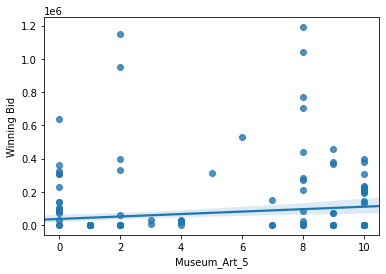

In [20]:
#Plot showing the weak relationship between the number of art galleries and museums around a property and the winning bid
# As can be seen, it is a weak correlation

sns.regplot(x="Museum_Art_5", y="Winning Bid", data=df)

Now let us compare this with a graph of Opening Bid vs. Winning Bid. We can see that there is a strong linear relationship between the two.

<AxesSubplot:xlabel='Opening Bid', ylabel='Winning Bid'>

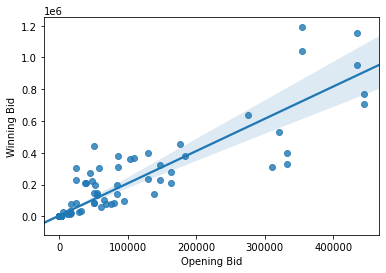

In [21]:
sns.regplot(x="Opening Bid", y="Winning Bid", data=df)

In [37]:
#Now we will begin the model building process with our chosen variables
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = df[['Land Value','Improvements','Opening Bid','TOTAL_LVG_','BEDROOMS','BATHS']]
y = df['Winning Bid']

# split data into train/test
msk = np.random.rand(len(df)) < 0.8
train_x = X[msk]
test_x = X[~msk]
train_y = y[msk]
test_y = y[~msk]

#create pipeline
Input2 = [('scale',StandardScaler()), ('model',LinearRegression())]
pipe2 = Pipeline(Input2)

# build the model using train set
pipe2.fit(train_x,train_y)

# predict using test set
y_hat=pipe2.predict(test_x)
y_hat[0:4]

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y))

Mean absolute error: 49996.04
Residual sum of squares (MSE): 20971583066.12
R2-score: 0.73


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


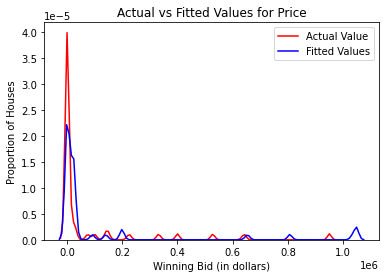

In [38]:
#Plot the distribution plots of both the actual and fitted values for winning bid price

plt.figure()

ax1 = sns.distplot(test_y, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Winning Bid (in dollars)')
plt.ylabel('Proportion of Houses')

plt.show()
plt.close()

From the R^2 score, We can say that ~ 73% of the variation of the Winning Bid is explained by our model. This is not bad, but future iterations can improve on this. 

From the distribution of fitted and actual values, we can see that the fitted values are reasonably close to the actual values since there is much overlap. Again, there is room for improvement though.

In [68]:
# So that we can duplicate this analysis at a later time
train_x.to_pickle('train_x')
test_x.to_pickle('test_x')
train_y.to_pickle('train_y')
test_y.to_pickle('test_y')

<a id='item2b'></a>

<a id='item3'></a>

## Analysis of Potential Profit

We will now apply our model to the upcoming auction data. 

<a id='item3a'></a>

### Estimate Winning Bids

<a id='item3b'></a>

In [102]:
#Apply model to upcoming auction data
#We won't produce estimates for two records where we're missing the number of bedrooms and baths

auctiondata5 = auctiondata4[['APN','Land Value','Improvements','Opening Bid','TOTAL_LVG_','BEDROOMS','BATHS']].dropna()
auctiondata5 = auctiondata5.reset_index()

AuctionPredictions = pipe2.predict(auctiondata5[['Land Value','Improvements','Opening Bid','TOTAL_LVG_','BEDROOMS','BATHS']])
auctiondata5['AuctionPredictions'] = pd.Series(AuctionPredictions)

print(len(auctiondata4),len(auctiondata5),len(AuctionPredictions))
auctiondata5.head()

42 40 40


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,index,APN,Land Value,Improvements,Opening Bid,TOTAL_LVG_,BEDROOMS,BATHS,AuctionPredictions
0,0,1023622000,116469,88498,101000,1152,3.0,2.0,272701.135110
1,1,1211304300,124409,348619,232000,2156,3.0,2.0,409508.835716
2,2,1213223100,225195,225195,221000,1812,2.0,2.0,493467.658625
3,3,1233402300,103536,169812,134000,2840,3.0,3.0,268101.581052
4,4,1292110800,169793,318362,240000,2314,3.0,2.0,460493.679342


### Estimate Sale Prices with Zestimate API

<a id='item3c'></a>

In [73]:
# There was a Zillow API that has recently been discontinued. See: https://twitter.com/zillow/status/1365418247949058048
# I attempted to web scrape with BeautifulSoup and was blocked
# I attempted to use a get request on another part of Zillow and was blocked
# I searched other services, but they required a subscription
# Instead, I manually searched the 42 properties and recorded their Zestimates from Zillow (where available)

zestimates = pd.read_csv('UpcomingAuction_Zestimates.csv')
zestimates.head()

,APN,Street Address,Zestimate,Notes
0,1023622000,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,500828.0,NaN
1,1211304300,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,906210.0,NaN
2,1213223100,3816 CAZADOR LN FALLBROOK CA 92028-8880,703622.0,NaN
3,1233402300,4577 LA CANADA RD FALLBROOK CA 92028-9488,508988.0,NaN
4,1292110800,10079 W LILAC RD ESCONDIDO CA 92026-5308,710429.0,NaN


In [103]:
#Merge Zestimates onto auctiondata5

auctiondata5 = auctiondata5.join(zestimates.set_index('APN'), on='APN').dropna(subset=['Zestimate'])
auctiondata5

,index,APN,Land Value,Improvements,Opening Bid,TOTAL_LVG_,BEDROOMS,BATHS,AuctionPredictions,Street Address,Zestimate,Notes
0,0,1023622000,116469,88498,101000,1152,3.0,2.0,2.727011e+05,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,500828.0,NaN
1,1,1211304300,124409,348619,232000,2156,3.0,2.0,4.095088e+05,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,906210.0,NaN
2,2,1213223100,225195,225195,221000,1812,2.0,2.0,4.934677e+05,3816 CAZADOR LN FALLBROOK CA 92028-8880,703622.0,NaN
3,3,1233402300,103536,169812,134000,2840,3.0,3.0,2.681016e+05,4577 LA CANADA RD FALLBROOK CA 92028-9488,508988.0,NaN
4,4,1292110800,169793,318362,240000,2314,3.0,2.0,4.604937e+05,10079 W LILAC RD ESCONDIDO CA 92026-5308,710429.0,NaN
5,5,1292923600,529698,390651,452000,3170,4.0,3.0,1.083472e+06,11146 OLD CASTLE RD VALLEY CENTER CA 92082-5605,912775.0,NaN
6,6,1293303400,673783,30620,346000,690,1.0,1.0,1.092613e+06,30642 ROLLING HILLS DR VALLEY CENTER CA 92082-...,690592.0,NaN
7,7,1413843900,136000,664000,375000,5258,5.0,4.5,5.478922e+05,343 VERBENA DR BORREGO SPRINGS CA 92004-4374,79900.0,NaN
8,9,1654130600,9690,25747,18000,827,2.0,1.0,4.254203e+04,3151 CALLE OSUNA OCEANSIDE CA 92056-3941,416077.0,NaN
9,10,1741311800,168894,168894,166000,1521,2.0,2.0,3.796268e+05,1443 WARMLANDS AVE VISTA CA 92084-3623,640942.0,NaN


### Calculate Potential Profit for each Property

In [113]:
#Simple process to determine a rudimentary calculation for profit

auctiondata5['Profit'] = (auctiondata5.Zestimate - auctiondata5.AuctionPredictions).apply(lambda x: "${:,.2f}".format(x))

auctiondata5.sort_values(by='Profit', ascending=False)

,index,APN,Land Value,Improvements,Opening Bid,TOTAL_LVG_,BEDROOMS,BATHS,AuctionPredictions,Street Address,Zestimate,Notes,Profit
27,28,4530125333,27007,33763,30000,378,1.0,1.0,7.414468e+04,3796 ALABAMA ST #122 SAN DIEGO CA 92104-8315,168765.0,NaN,"$94,620.32"
32,33,4962723200,217865,448877,327000,4682,4.0,4.5,6.045964e+05,4470 RESMAR RD LA MESA CA 91941-6870,1538335.0,NaN,"$933,738.64"
21,22,3530321706,824201,261753,533000,2938,3.0,3.0,1.467951e+06,6573 CAMINITO BLYTHEFIELD LA JOLLA CA 92037-5806,2199090.0,NaN,"$731,138.69"
30,31,4670521000,31873,65251,48000,1776,3.0,1.5,9.506993e+04,5127 E FALLS VIEW DR SAN DIEGO CA 92115-1420,816025.0,NaN,"$720,955.07"
18,19,3003214614,177533,158510,165000,1279,2.0,2.0,3.940398e+05,229 SEA FOREST CT DEL MAR CA 92014-3245,1016142.0,NaN,"$622,102.25"
19,20,3132101700,80214,86906,82000,1246,3.0,2.0,2.099437e+05,11176 ALMAZON ST SAN DIEGO CA 92129-1002,765126.0,NaN,"$555,182.27"
1,1,1211304300,124409,348619,232000,2156,3.0,2.0,4.095088e+05,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,906210.0,NaN,"$496,701.16"
11,12,1854123200,281494,793815,528000,7349,5.0,7.5,9.064262e+05,29548 MEADOW GLEN WAY W ESCONDIDO CA 92026-6513,1353347.0,NaN,"$446,920.82"
37,39,6205700700,39412,106910,72000,1206,3.0,2.0,1.588321e+05,1205 MISSION AVE CHULA VISTA CA 91911-3709,586419.0,NaN,"$427,586.95"
8,9,1654130600,9690,25747,18000,827,2.0,1.0,4.254203e+04,3151 CALLE OSUNA OCEANSIDE CA 92056-3941,416077.0,NaN,"$373,534.97"


In [114]:
auctiondata5.to_pickle('auctiondata5')

<a id='item4'></a>

## Conclusion and Recommendations

From this analysis, we can see the beginnings of a model that can be used before an auction to help an investor determine which properties they should target for bidding. Depending on the amount of money an investor has, this model can help pinpoint which properties can allow the most profit for a given amount of investment. Of course, this model should be used as a tool and not the absolute determining factor for investing. There are other factors which are not in any dataset we can access. One big piece of information that can help an investor is by knowing the current state of a house. Some questions to consider are: is the house in ruins, does it look recently upgraded, and are there current tenants that you will need to potentially evict? Of course, investors usually don't have enough time to physically go to each address and visually inspect the property. This is where the value of this model comes in. It can help an investor focus on which properties can provide the most upside for an investment. From there, the investor can do further investigation for a handful of properties instead of all of the available properties.

This model is useful, but not perfect. It does have its limitations. We will go through some of these now.

<ul>
    <li>Having resources to access premium calls on Foursquare, would have allowed us to test our hypothesis of valuable properties being near "upscale" venues.</li>
    <li>Originally, this project was going to use housing sales data to model the price of each property. This could have served as an additional feature to estimate "Winning Bid". We did receive data, but the data was only for single family homes and was missing all condo data. Further, this data was capped at houses that sold for &#36;1.5M and less. We had many properties in our auction data that we would have needed to exclude due to lack of housing sales data</li>
    <li>The real estate data that we were going to use was only for the city of San Diego and not for the county. Since there were already a small amount of properties to choose from in our auction list, only choosing properties in the city of San Diego would have severely limited our choices. We would not have had as robust of an analysis.</li>
    <li>This tool is not scalable for all people to have. The more people know what the forecasted winning bid might be, the more potential for influence in their own decision to bid or not. This model does not take into account what the winning bid might be if multiple people are using this tool. Knowing what another investor might bid, could bias your decisions on bidding.</li>
</ul>

Releasing the limitation on any one of these issues would most likely improve our model.

Now that we have gone through some of the limitations, we'll go through some of the recommendations that one can take to improve on this model.

<ul>
    <li>We could expand this model by introducing new features that may help better estimate "Winning Bid". One such feature could be to see how the amount of people participating in an auction influences the winning bid price. The hypothesis could be that the more people that participate in an auction, the more competitive an auction might be. This competition would drive up the winning bid price. For future iterations of this model, it would be beneficial to to track the amount of people participating in these auctions.</li>
    <li>Another improvement on this process could be to team up with an actual investor and ask if they could give resources to build a better model. With these resources, we could release the limit of regular and premium calls we make to Foursquare.</li>
    <li>In a next iteration of this model, we should include improved land properties. There are great investment opportunities in land only properties. The next iteration of this analysis should highly consider including land only properties to allow for more possibilities of finding a good deal.</li>
</ul>

Overall, more improvements can be taken to better model winning bids in our property auctions. This project shows though that there is a systematic and quantitative way to classify what a "good" bid might be on a property. This tool shows its value to an investor by filtering down which properties have the potential for high profits and which properties could prove to be pitfalls in just a few minutes of runtime. Through muliple linear regression, we have created a tool that can predict the winning bid of a property. This tools helps investors budget for each property and saves time by knowing which properties to further research.

In [2]:
# Scratch work for exploratory and inserting tables/figures in report

auctiondata5 = pd.read_pickle('auctiondata5')
auctiondata5

,index,APN,Land Value,Improvements,Opening Bid,TOTAL_LVG_,BEDROOMS,BATHS,AuctionPredictions,Street Address,Zestimate,Notes,Profit
0,0,1023622000,116469,88498,101000,1152,3.0,2.0,2.727011e+05,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,500828.0,NaN,"$228,126.86"
1,1,1211304300,124409,348619,232000,2156,3.0,2.0,4.095088e+05,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,906210.0,NaN,"$496,701.16"
2,2,1213223100,225195,225195,221000,1812,2.0,2.0,4.934677e+05,3816 CAZADOR LN FALLBROOK CA 92028-8880,703622.0,NaN,"$210,154.34"
3,3,1233402300,103536,169812,134000,2840,3.0,3.0,2.681016e+05,4577 LA CANADA RD FALLBROOK CA 92028-9488,508988.0,NaN,"$240,886.42"
4,4,1292110800,169793,318362,240000,2314,3.0,2.0,4.604937e+05,10079 W LILAC RD ESCONDIDO CA 92026-5308,710429.0,NaN,"$249,935.32"
5,5,1292923600,529698,390651,452000,3170,4.0,3.0,1.083472e+06,11146 OLD CASTLE RD VALLEY CENTER CA 92082-5605,912775.0,NaN,"$-170,696.95"
6,6,1293303400,673783,30620,346000,690,1.0,1.0,1.092613e+06,30642 ROLLING HILLS DR VALLEY CENTER CA 92082-...,690592.0,NaN,"$-402,021.13"
7,7,1413843900,136000,664000,375000,5258,5.0,4.5,5.478922e+05,343 VERBENA DR BORREGO SPRINGS CA 92004-4374,79900.0,NaN,"$-467,992.19"
8,9,1654130600,9690,25747,18000,827,2.0,1.0,4.254203e+04,3151 CALLE OSUNA OCEANSIDE CA 92056-3941,416077.0,NaN,"$373,534.97"
9,10,1741311800,168894,168894,166000,1521,2.0,2.0,3.796268e+05,1443 WARMLANDS AVE VISTA CA 92084-3623,640942.0,NaN,"$261,315.18"


In [3]:
auctiondata5.shape

(38, 13)

In [4]:
auctiondata5.describe(include='all')

,index,APN,Land Value,Improvements,Opening Bid,TOTAL_LVG_,BEDROOMS,BATHS,AuctionPredictions,Street Address,Zestimate,Notes,Profit
count,38.000000,3.800000e+01,3.800000e+01,38.000000,3.800000e+01,38.000000,38.000000,38.000000,3.800000e+01,38,3.800000e+01,0,38
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,0,38
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30642 ROLLING HILLS DR VALLEY CENTER CA 92082-...,NaN,NaN,"$104,534.08"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
mean,20.684211,3.426656e+09,3.407755e+05,224933.868421,2.766316e+05,1914.421053,2.815789,2.223684,6.864524e+05,NaN,8.101958e+05,NaN,NaN
std,12.514004,1.781609e+09,6.867771e+05,209696.444439,3.978971e+05,1471.844708,1.204839,1.287662,1.158979e+06,NaN,8.027927e+05,NaN,NaN
min,0.000000,1.023622e+09,9.690000e+03,5100.000000,1.800000e+04,0.000000,0.000000,0.000000,4.254203e+04,NaN,7.990000e+04,NaN,NaN
25%,10.250000,1.768767e+09,8.311050e+04,75681.250000,8.425000e+04,1087.000000,2.000000,1.625000,1.969366e+05,NaN,4.570220e+05,NaN,NaN
50%,21.500000,3.522481e+09,1.693435e+05,147142.000000,1.675000e+05,1639.000000,3.000000,2.000000,4.280583e+05,NaN,6.386090e+05,NaN,NaN
75%,30.750000,4.662942e+09,2.769618e+05,311629.000000,2.887500e+05,2278.500000,3.750000,3.000000,6.005503e+05,NaN,7.898655e+05,NaN,NaN


In [6]:
auctiondata3 = pd.read_pickle('auctiondata3')

sd_lat = 32.7157
sd_long= -117.1611

map_sd = folium.Map(location=[sd_lat, sd_long], zoom_start=9)

# add markers to map
for lat, lng, bid, value, addy in zip(auctiondata3['Latitude'], auctiondata3['Longitude'], auctiondata3['Opening Bid'], auctiondata3['Total Assessed Value'],auctiondata3['Street Address']):
    label = 'Address: Opening Bid: {}, Total Assessed Value: {}'.format(bid, value)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sd)  
    
map_sd

Text(0, 0.5, 'Number of Properties')

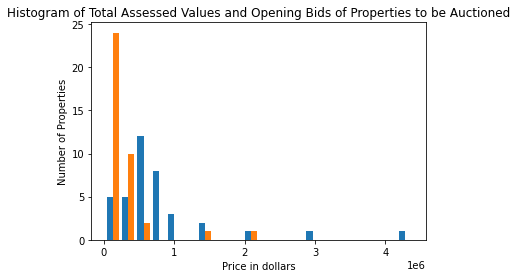

In [20]:
plt.hist(auctiondata5[['Zestimate','Opening Bid']],bins=20)

plt.title('Histogram of Total Assessed Values and Opening Bids of Properties to be Auctioned')
plt.xlabel('Price in dollars')
plt.ylabel('Number of Properties') 

#auctiondata3.head()                      

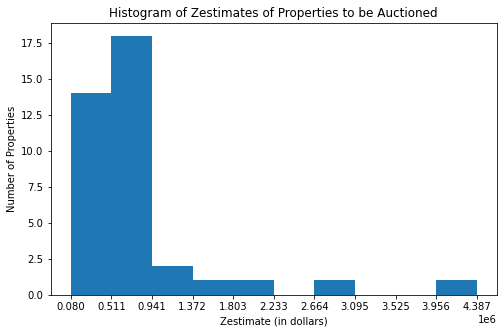

In [22]:
count, bin_edges = np.histogram(auctiondata5['Zestimate'])

auctiondata5['Zestimate'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Zestimates of Properties to be Auctioned') # add a title to the histogram
plt.ylabel('Number of Properties') # add y-label
plt.xlabel('Zestimate (in dollars)') # add x-label

plt.show()

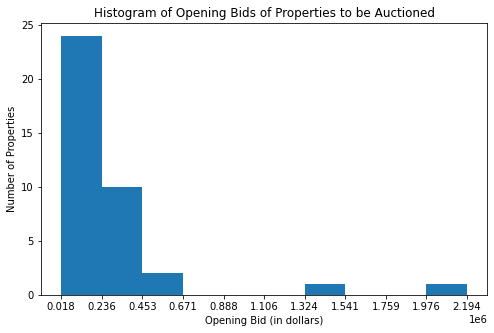

In [25]:
count, bin_edges = np.histogram(auctiondata5['Opening Bid'])

auctiondata5['Opening Bid'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Opening Bids of Properties to be Auctioned') # add a title to the histogram
plt.ylabel('Number of Properties') # add y-label
plt.xlabel('Opening Bid (in dollars)') # add x-label

plt.show()

In [28]:
auctiondata3.head(2)

,ID#,APN,Street Address,Tax Rate Area,Land Value,Improvements,Total Assessed Value,Property Description,Opening Bid,Canceled,Latitude,Longitude,Museum_Art_1,Racecourse_1,Zoo_1,GolfCourse_1,Bay_Beach_1,NtnlPark_Preserve_1,ER_1,Museum_Art_5,Racecourse_5,Zoo_5,GolfCourse_5,Bay_Beach_5,NtnlPark_Preserve_5,ER_5
0,5,1023622000,5710 RAINBOW HEIGHTS RD FALLBROOK CA 92028-8844,93011,116469,88498,204967,(EX RD)PAR A PER DOC89-510014 IN SEQ OF SEQ SE...,101000,NaN,33.426140,-117.102790,0,0,0,0,0,0,0,9,1,0,9,3,0,2
1,22,1211304300,4782 SLEEPING INDIAN RD FALLBROOK CA 92028-8875,75015,124409,348619,473028,DOC59-6680 IN SWQ SEC 13-10-4W,232000,NaN,33.306046,-117.261136,0,0,0,0,0,0,0,9,1,0,9,4,2,4


In [34]:
df = histauctdata3[['Land Value','Improvements','Opening Bid','Museum_Art_1','Racecourse_1','Zoo_1','GolfCourse_1','Bay_Beach_1','NtnlPark_Preserve_1','ER_1','Museum_Art_5','Racecourse_5',
        'Zoo_5','GolfCourse_5','Bay_Beach_5','NtnlPark_Preserve_5','ER_5','TOTAL_LVG_','BEDROOMS','BATHS','Winning Bid']].dropna()

In [ ]:
sns.regplot(x="Opening Bid", y="Winning Bid", data=df)

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
df_CI.plot(kind='box', color='blue', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box Plots of Immigrants from China and India (1980 - 2013)')
ax0.set_xlabel('Number of Immigrants')
ax0.set_ylabel('Countries')

# Subplot 2: Line plot
df_CI.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line Plots of Immigrants from China and India (1980 - 2013)')
ax1.set_ylabel('Number of Immigrants')
ax1.set_xlabel('Years')

plt.show()

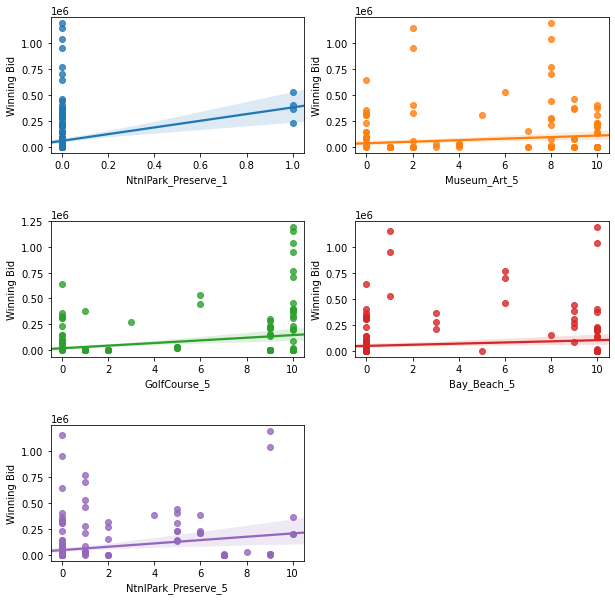

In [69]:
fig = plt.figure(figsize=(10,10)) # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

ax2 = fig.add_subplot(3, 2, 3) # add subplot 1 (1 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 2 (1 row, 2 columns, fourth plot). See tip below**

ax4 = fig.add_subplot(3, 2, 5) # add subplot 1 (1 row, 2 columns, fifth plot)


sns.regplot(x="NtnlPark_Preserve_1", y="Winning Bid", data=df, ax=ax0)
sns.regplot(x="Museum_Art_5", y="Winning Bid", data=df, ax=ax1)
sns.regplot(x="GolfCourse_5", y="Winning Bid", data=df, ax=ax2)
sns.regplot(x="Bay_Beach_5", y="Winning Bid", data=df, ax=ax3)
sns.regplot(x="NtnlPark_Preserve_5", y="Winning Bid", data=df, ax=ax4)

fig.subplots_adjust(hspace=.5)
plt.show()

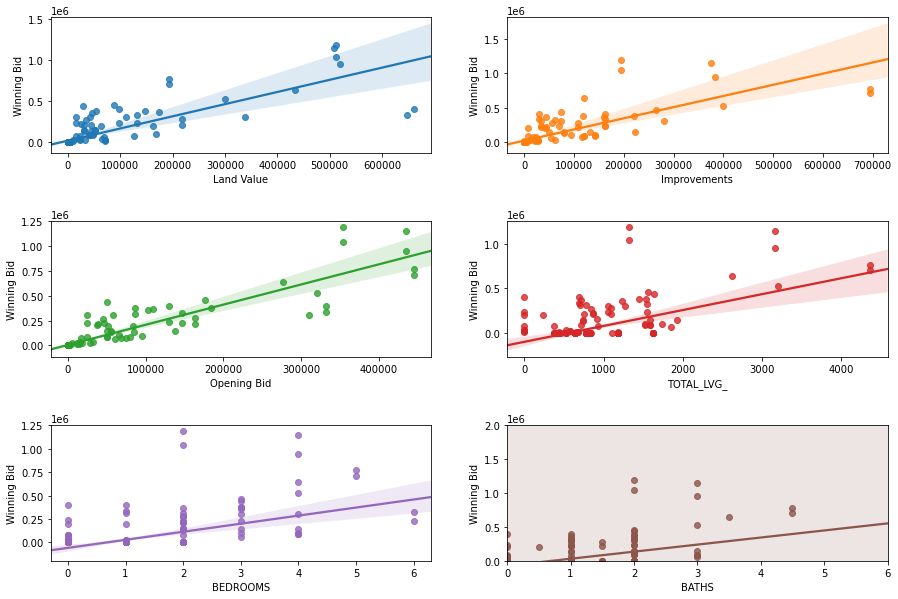

In [84]:
fig = plt.figure(figsize=(15,10)) # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

ax2 = fig.add_subplot(3, 2, 3) # add subplot 1 (1 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 2 (1 row, 2 columns, fourth plot). See tip below**

ax4 = fig.add_subplot(3, 2, 5) # add subplot 1 (1 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 1 (1 row, 2 columns, fifth plot)


sns.regplot(x="Land Value", y="Winning Bid", data=df, ax=ax0)
sns.regplot(x="Improvements", y="Winning Bid", data=df, ax=ax1)
sns.regplot(x="Opening Bid", y="Winning Bid", data=df, ax=ax2)
sns.regplot(x="TOTAL_LVG_", y="Winning Bid", data=df, ax=ax3)
sns.regplot(x="BEDROOMS", y="Winning Bid", data=df, ax=ax4)
sns.regplot(x="BATHS", y="Winning Bid", data=df, ax=ax5)

ax5.set_xlim(0,6)
ax5.set_ylim(-1000,2000000)

fig.subplots_adjust(hspace=.5)
plt.show()

<AxesSubplot:xlabel='BATHS', ylabel='Winning Bid'>

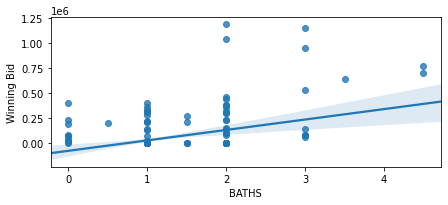

In [89]:
fig = plt.figure(figsize=(7,2.75))
sns.regplot(x="BATHS", y="Winning Bid", data=df)

In [90]:
df.shape

(254, 21)